## Data Preparation and Analysis


In [1]:
from sklearn.preprocessing import MinMaxScaler
import sklearn
import sklearn.preprocessing
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time

import torch
import torch.nn as nn

In [2]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv("prices-split-adjusted.csv",index_col='date', parse_dates=['date'])
#df.describe()
df.head()
#df.info()



Saving prices-split-adjusted.csv to prices-split-adjusted (3).csv


,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [3]:
#Removing data with less than 1762 entries
symbol_counts = df['symbol'].value_counts()
omit = symbol_counts[symbol_counts < 1762].index
df_filtered = df[~df['symbol'].isin(omit)]

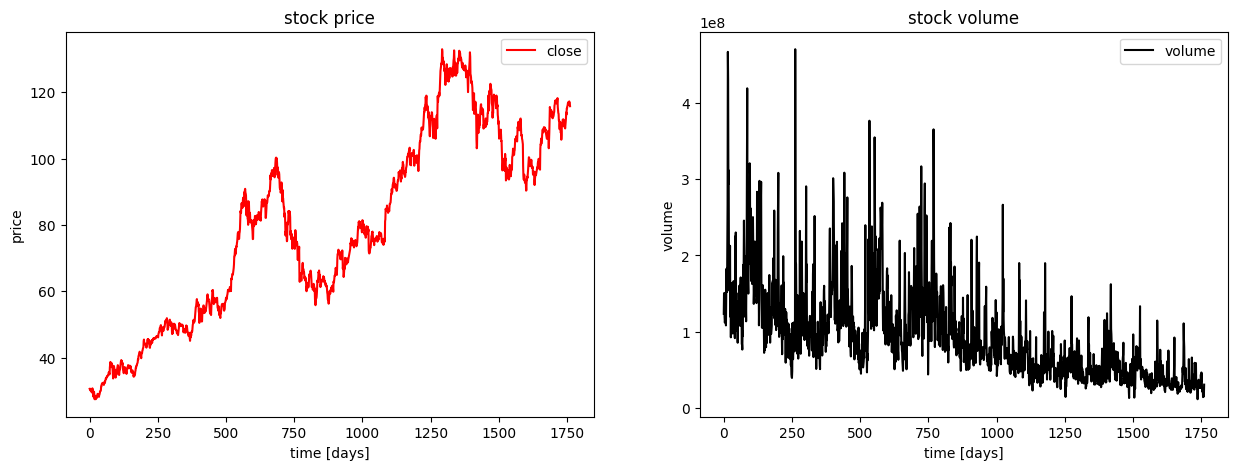

In [4]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(df[df.symbol == 'AAPL'].close.values, color='red', label='close')

plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')

plt.subplot(1,2,2);
plt.plot(df[df.symbol == 'AAPL'].volume.values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best')

## Data Normalization


In [5]:
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df['open'].values.reshape(-1, 1))
    df['high'] = min_max_scaler.fit_transform(df['high'].values.reshape(-1, 1))
    df['low'] = min_max_scaler.fit_transform(df['low'].values.reshape(-1, 1))
    df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1, 1))
    return df

# Normalize the stock data
df_stock = df[df.symbol == 'AAPL'].copy()
df_stock.drop(['symbol', 'volume'], axis=1, inplace=True)
df_stock_norm = normalize_data(df_stock)

In [6]:
if df_stock_norm.isna().any().any():
    # Replace NA values with the median of their respective column
    df_stock_norm.fillna(df_stock_norm.median(), inplace=True)

In [7]:
from scipy import stats
# Calculating Z-scores of the dataset
z_scores = stats.zscore(df_stock_norm)

# Setting a threshold for identifying outliers
threshold = 3

# Identifying indices where any column has a Z-score greater than the threshold
outliers = (abs(z_scores) > threshold).any(axis=1)

# Getting the indices of these outliers
outlier_indices = df_stock_norm[outliers].index.tolist()

# Printing the indices of outliers
print("Indices of extreme outliers:", outlier_indices)

Indices of extreme outliers: []


## Linear Regression Model


In [8]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
# Define features and target for Linear Regression
features_lr = df_stock_norm[['open', 'high', 'low', 'close']].values
target_lr = df_stock_norm['close'].values

# Split the data for Linear Regression
X_train_lr, X_val_lr, y_train_lr, y_val_lr = train_test_split(features_lr, target_lr, test_size=0.2, random_state=42)

# Convert the data to PyTorch tensors for Linear Regression
X_train_tensor_lr = torch.tensor(X_train_lr, dtype=torch.float32)
y_train_tensor_lr = torch.tensor(y_train_lr, dtype=torch.float32).view(-1, 1)
X_val_tensor_lr = torch.tensor(X_val_lr, dtype=torch.float32)
y_val_tensor_lr = torch.tensor(y_val_lr, dtype=torch.float32).view(-1, 1)

# Create Tensor datasets for Linear Regression
train_data_lr = TensorDataset(X_train_tensor_lr, y_train_tensor_lr)
val_data_lr = TensorDataset(X_val_tensor_lr, y_val_tensor_lr)

# Create Data Loaders for Linear Regression
batch_size_lr = 64
train_loader_lr = DataLoader(train_data_lr, shuffle=True, batch_size=batch_size_lr)
val_loader_lr = DataLoader(val_data_lr, batch_size=batch_size_lr)

In [9]:
# Define the Linear Regression Model
class LinearRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)

# Instantiate the Linear Regression model
input_size_lr = X_train_lr.shape[1]  # Make sure this is correct based on your features
model_lr = LinearRegressionModel(input_size_lr)


In [10]:
def train(model, train_loader, valid_loader, criterion=nn.MSELoss(), num_epochs=300, learning_rate=0.001):
    train_losses, valid_losses = [], []
    train_errors, valid_errors = [], []
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0
        total_train_error = 0.0
        for features, labels in train_loader:
            output = model(features)
            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            total_train_error += torch.mean(torch.abs(output - labels)).item()

        total_valid_loss = 0.0
        total_valid_error = 0.0
        with torch.no_grad():
            model.eval()
            for features, labels in valid_loader:
                output = model(features)
                loss = criterion(output, labels)
                total_valid_loss += loss.item()
                total_valid_error += torch.mean(torch.abs(output - labels)).item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_valid_loss = total_valid_loss / len(valid_loader)
        avg_train_error = total_train_error / len(train_loader)
        avg_valid_error = total_valid_error / len(valid_loader)

        train_losses.append(avg_train_loss)
        valid_losses.append(avg_valid_loss)
        train_errors.append(avg_train_error)
        valid_errors.append(avg_valid_error)

        if epoch % 10 == 0:
            print(f"Epoch: {epoch+1}/{num_epochs}.. "
                  f"Train Loss: {avg_train_loss:.5f}.. "
                  f"Valid Loss: {avg_valid_loss:.5f}.. "
                  f"Train Error: {avg_train_error:.5f}.. "
                  f"Valid Error: {avg_valid_error:.5f}..")

    return train_losses, valid_losses, train_errors, valid_errors

# Instantiate and train the model
model_lr = LinearRegressionModel(input_size_lr)
train_losses_lr, valid_losses_lr, train_errors_lr, valid_errors_lr = train(model_lr, train_loader_lr, val_loader_lr, nn.MSELoss(), 300, 0.001)


Epoch: 1/300.. Train Loss: 0.05103.. Valid Loss: 0.04327.. Train Error: 0.18610.. Valid Error: 0.16984..
Epoch: 11/300.. Train Loss: 0.01891.. Valid Loss: 0.01747.. Train Error: 0.11326.. Valid Error: 0.11066..
Epoch: 21/300.. Train Loss: 0.00641.. Valid Loss: 0.00549.. Train Error: 0.06777.. Valid Error: 0.06173..
Epoch: 31/300.. Train Loss: 0.00140.. Valid Loss: 0.00124.. Train Error: 0.03118.. Valid Error: 0.02943..
Epoch: 41/300.. Train Loss: 0.00025.. Valid Loss: 0.00021.. Train Error: 0.01361.. Valid Error: 0.01218..
Epoch: 51/300.. Train Loss: 0.00004.. Valid Loss: 0.00003.. Train Error: 0.00511.. Valid Error: 0.00479..
Epoch: 61/300.. Train Loss: 0.00001.. Valid Loss: 0.00002.. Train Error: 0.00247.. Valid Error: 0.00272..
Epoch: 71/300.. Train Loss: 0.00001.. Valid Loss: 0.00002.. Train Error: 0.00212.. Valid Error: 0.00253..
Epoch: 81/300.. Train Loss: 0.00001.. Valid Loss: 0.00002.. Train Error: 0.00226.. Valid Error: 0.00256..
Epoch: 91/300.. Train Loss: 0.00001.. Valid Los

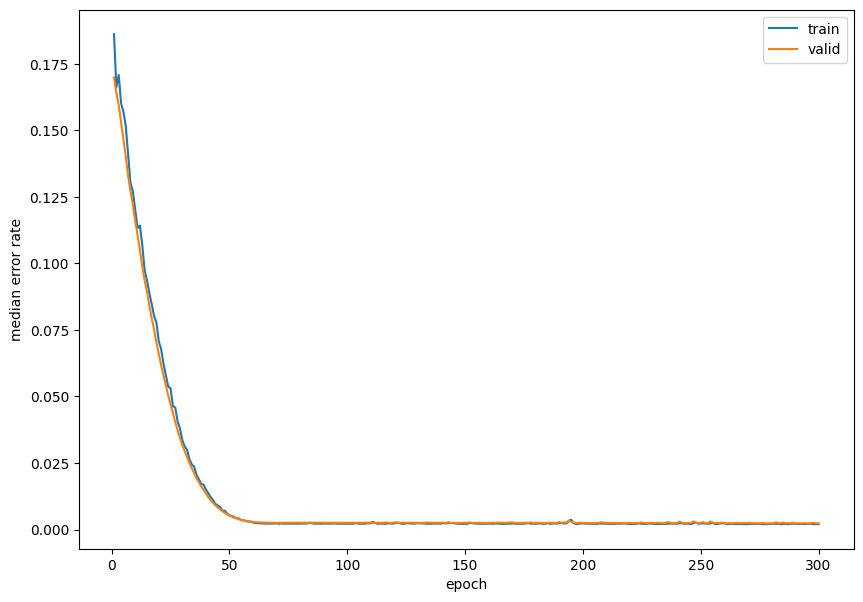

In [11]:
# Visualization for Linear Regression result
import matplotlib.pyplot as plt

def plot_errors(train_errors_lr, valid_errors_lr, num_epochs=300):
    plt.figure(figsize=(10, 7))
    plt.plot(range(1, num_epochs + 1), train_errors_lr, label='train')
    plt.plot(range(1, num_epochs + 1), valid_errors_lr, label='valid')
    plt.xlabel('epoch')
    plt.ylabel('median error rate')
    plt.legend()
    plt.show()
plot_errors(train_errors_lr, valid_errors_lr)

## Multi-layer Perceptron Base Model

In [12]:
# Build a feed-forward network for muti layer model

model = nn.Sequential(nn.Linear(features_lr.shape[1], 256),
                      nn.ReLU(),
                      nn.Linear(256, 128),
                      nn.ReLU(),
                      nn.Linear(128,1))

In [13]:
import itertools

# Define the parameter grid for hidden layers
hidden_layers_options = [
    [256, 128],
    [512, 256],
    [128, 64],
    [256, 128, 64],
    [512, 256, 128]
]
num_epochs = 200
fixed_lr = 0.001

# Function to create the model
def create_model(hidden_layers):
    layers = []
    input_size = features_lr.shape[1]  # Number of input features
    for hidden_layer_size in hidden_layers:
        layers.append(nn.Linear(input_size, hidden_layer_size))
        layers.append(nn.ReLU())
        input_size = hidden_layer_size
    layers.append(nn.Linear(hidden_layers[-1], 1))
    return nn.Sequential(*layers)

# Grid search only for hidden layer configurations
best_loss = float('inf')
best_params = {}

for hidden_layers in hidden_layers_options:
    model = create_model(hidden_layers)
    train_losses, valid_losses, train_errors, valid_errors = train(model, train_loader_lr, val_loader_lr, nn.MSELoss(), num_epochs, fixed_lr)


    avg_valid_loss = sum(valid_losses) / len(valid_losses)
    if avg_valid_loss < best_loss:
        best_loss = avg_valid_loss
        best_params = {
            'hidden_layers': hidden_layers
        }

print("Best Parameters:", best_params)


Epoch: 1/200.. Train Loss: 0.02016.. Valid Loss: 0.00439.. Train Error: 0.10238.. Valid Error: 0.05647..
Epoch: 11/200.. Train Loss: 0.00003.. Valid Loss: 0.00005.. Train Error: 0.00419.. Valid Error: 0.00522..
Epoch: 21/200.. Train Loss: 0.00003.. Valid Loss: 0.00004.. Train Error: 0.00401.. Valid Error: 0.00481..
Epoch: 31/200.. Train Loss: 0.00009.. Valid Loss: 0.00003.. Train Error: 0.00760.. Valid Error: 0.00408..
Epoch: 41/200.. Train Loss: 0.00004.. Valid Loss: 0.00008.. Train Error: 0.00508.. Valid Error: 0.00776..
Epoch: 51/200.. Train Loss: 0.00002.. Valid Loss: 0.00006.. Train Error: 0.00319.. Valid Error: 0.00664..
Epoch: 61/200.. Train Loss: 0.00001.. Valid Loss: 0.00001.. Train Error: 0.00241.. Valid Error: 0.00274..
Epoch: 71/200.. Train Loss: 0.00001.. Valid Loss: 0.00003.. Train Error: 0.00220.. Valid Error: 0.00467..
Epoch: 81/200.. Train Loss: 0.00001.. Valid Loss: 0.00003.. Train Error: 0.00191.. Valid Error: 0.00494..
Epoch: 91/200.. Train Loss: 0.00000.. Valid Los

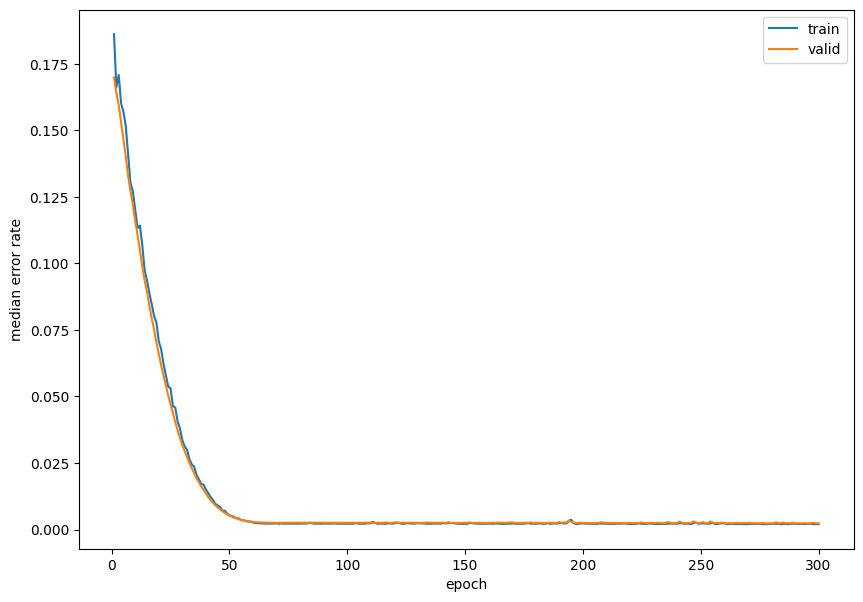

In [14]:
plot_errors(train_errors_lr, valid_errors_lr)

## RNN Model


In [15]:
price = df_stock[['close']]
scaler = MinMaxScaler(feature_range=(-1, 1))
price['close'] = scaler.fit_transform(price['close'].values.reshape(-1,1))

<ipython-input-15-071f966b3550>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['close'] = scaler.fit_transform(price['close'].values.reshape(-1,1))


In [16]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []

    # create a list of time series of window size lookback
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])

    data = np.array(data);
    # The last 20% of the data as test set
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    #assign the first lookback -1 time steps as input x and the last time step as target y
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]

    x_test = data[train_set_size:,:-1,:]
    y_test = data[train_set_size:,-1,:]

    return [x_train, y_train, x_test, y_test]

In [17]:
lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1394, 19, 1)
y_train.shape =  (1394, 1)
x_test.shape =  (348, 19, 1)
y_test.shape =  (348, 1)


In [18]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [19]:
class RNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers):
        super(RNN, self).__init__()

        #define an RNN with specified parameters
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        #define last, fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_dim)
        # hidden (num_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)

        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden)
        # get output at the last time step
        output = self.fc(r_out[:, -1, :])
        return output, hidden

In [20]:
# decide on hyperparameters
input_dim=1
output_dim=1
hidden_dim=32
num_layers=2

# instantiate an RNN
rnn = RNN(input_dim, output_dim, hidden_dim, num_layers)
print(rnn)

# MSE loss and Adam optimizer with a learning rate of 0.001
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)

def train(model, x_train, y_train, num_epochs):
  start_time = time.time()
  train_losses = np.zeros(num_epochs)

  for t in range(num_epochs):
      tot_train_loss = 0

      # initialize the hidden state
      hidden = None

      #1. compute outputs from the rnn
      y_train_pred, hidden = model(x_train, hidden)
      #2. calculate the loss
      loss = criterion(y_train_pred, y_train)
      #3. zero out gradients
      optimizer.zero_grad()
      #4. perform backprop
      loss.backward()
      #5. update weights
      optimizer.step()

      print("Epoch ", t, "MSE: ", loss.item())
      train_losses[t] = loss.item()
  training_time = time.time()-start_time
  print("Training time: {}".format(training_time))
  return y_train_pred, train_losses, training_time

rnn_train_pred, train_losses, training_time =train(rnn, x_train, y_train,num_epochs=200)

RNN(
  (rnn): RNN(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
Epoch  0 MSE:  0.23113830387592316
Epoch  1 MSE:  0.2187037467956543
Epoch  2 MSE:  0.2076844722032547
Epoch  3 MSE:  0.19662044942378998
Epoch  4 MSE:  0.18477287888526917
Epoch  5 MSE:  0.1718495786190033
Epoch  6 MSE:  0.15769068896770477
Epoch  7 MSE:  0.1422240436077118
Epoch  8 MSE:  0.12545444071292877
Epoch  9 MSE:  0.10747312754392624
Epoch  10 MSE:  0.0884886384010315
Epoch  11 MSE:  0.0688600242137909
Epoch  12 MSE:  0.04919051751494408
Epoch  13 MSE:  0.03058740496635437
Epoch  14 MSE:  0.015013055875897408
Epoch  15 MSE:  0.005335190333425999
Epoch  16 MSE:  0.0043177236802875996
Epoch  17 MSE:  0.011998414993286133
Epoch  18 MSE:  0.023303065448999405
Epoch  19 MSE:  0.030365660786628723
Epoch  20 MSE:  0.0300432238727808
Epoch  21 MSE:  0.024453697726130486
Epoch  22 MSE:  0.01691729761660099
Epoch  23 MSE:  0.010048096999526024
Epoch  24 MSE:  0.005368823

In [21]:
predict = pd.DataFrame(scaler.inverse_transform(rnn_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train.detach().numpy()))

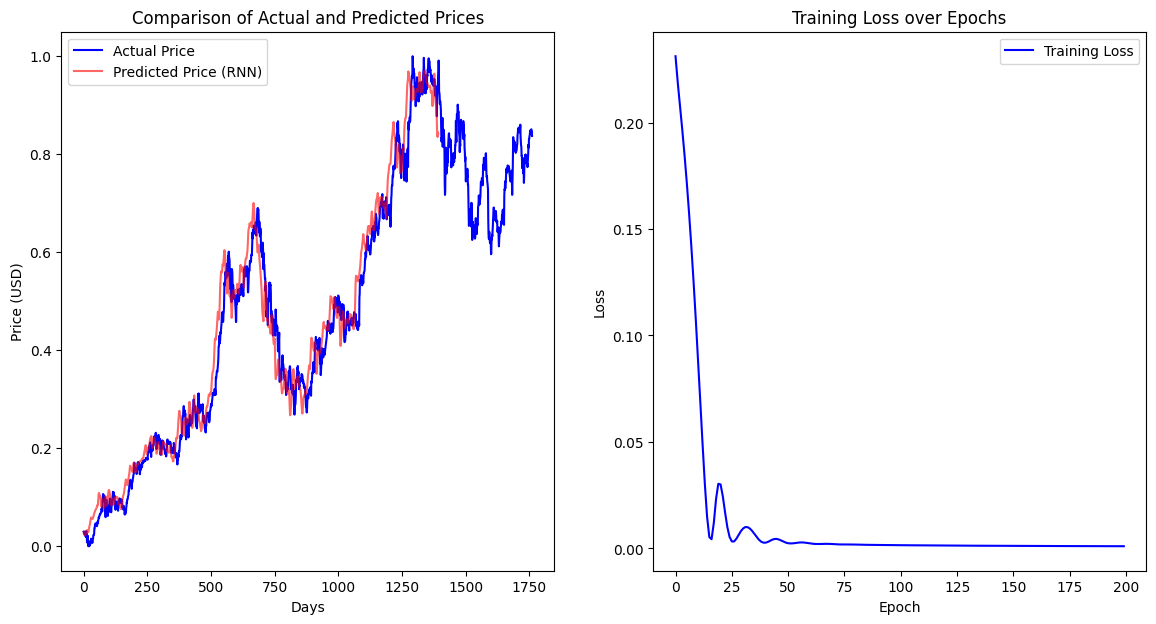

In [22]:
# Plotting the actual and predicted prices
plt.figure(figsize=(14,7))

# First subplot
plt.subplot(1, 2, 1)
plt.plot(df_stock['close'].values, label='Actual Price', color='blue')
plt.plot(predict, label='Predicted Price (RNN)', color='red', alpha=0.6)
plt.xlabel('Days')
plt.ylabel('Price (USD)')
plt.title('Comparison of Actual and Predicted Prices')
plt.legend()

# Second subplot
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.show()


## LSTM Model

In [23]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        #Define LSTM model
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        #Define the final, fully-connected output layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x (batch_size, seq_length, input_dim)
        # hidden (num_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)

        # Here we initialize the hidden states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()  #short term memory
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()  #long term memory

        ## Get the outputs and the new hidden state from the lstm
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        ## Put out through the fully-connected layer
        out = self.fc(out[:, -1, :])
        return out

In [24]:
lstm = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)

In [25]:
def train(model, x_train, y_train, num_epochs):
    train_losses = np.zeros(num_epochs)
    start_time = time.time()
    for t in range(num_epochs):
      y_train_pred = model(x_train)
      loss = criterion(y_train_pred, y_train)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      print("Epoch ", t, "MSE: ", loss.item())
      train_losses[t] = loss.item()

    training_time = time.time()-start_time
    print("Training time: {}".format(training_time))
    return y_train_pred, train_losses,training_time




In [26]:
lstm_train_pred, train_losses,training_time=train(lstm, x_train, y_train, num_epochs=200)

Epoch  0 MSE:  0.2765175700187683
Epoch  1 MSE:  0.27152326703071594
Epoch  2 MSE:  0.26697584986686707
Epoch  3 MSE:  0.26280808448791504
Epoch  4 MSE:  0.2589586079120636
Epoch  5 MSE:  0.255370557308197
Epoch  6 MSE:  0.25199368596076965
Epoch  7 MSE:  0.2487795203924179
Epoch  8 MSE:  0.24567729234695435
Epoch  9 MSE:  0.24263159930706024
Epoch  10 MSE:  0.23957988619804382
Epoch  11 MSE:  0.2364499717950821
Epoch  12 MSE:  0.23315967619419098
Epoch  13 MSE:  0.229619562625885
Epoch  14 MSE:  0.22573764622211456
Epoch  15 MSE:  0.22142426669597626
Epoch  16 MSE:  0.2165948748588562
Epoch  17 MSE:  0.21117044985294342
Epoch  18 MSE:  0.20507636666297913
Epoch  19 MSE:  0.19823943078517914
Epoch  20 MSE:  0.19058507680892944
Epoch  21 MSE:  0.1820354014635086
Epoch  22 MSE:  0.17250977456569672
Epoch  23 MSE:  0.1619296669960022
Epoch  24 MSE:  0.1502317190170288
Epoch  25 MSE:  0.13739389181137085
Epoch  26 MSE:  0.12348169833421707
Epoch  27 MSE:  0.10871955007314682
Epoch  28 MSE:

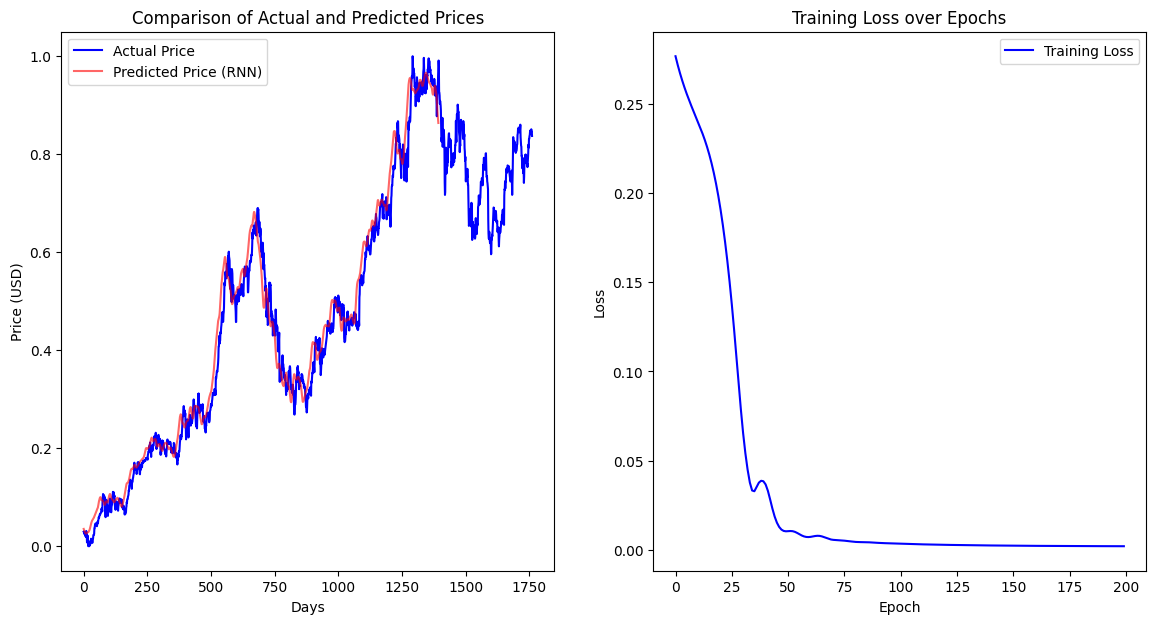

In [27]:
predict = pd.DataFrame(scaler.inverse_transform(lstm_train_pred.detach().numpy()))

# Plotting the actual and predicted prices
plt.figure(figsize=(14,7))

# First subplot
plt.subplot(1, 2, 1)
plt.plot(df_stock['close'].values, label='Actual Price', color='blue')
plt.plot(predict, label='Predicted Price (RNN)', color='red', alpha=0.6)
plt.xlabel('Days')
plt.ylabel('Price (USD)')
plt.title('Comparison of Actual and Predicted Prices')
plt.legend()

# Second subplot
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

plt.show()
